# MPP, PP, and so on

In [1]:
def oriented_graph(P, c):
    G = DiGraph()
    for (u, v, lab) in P.graph().edges():
        gap = v.vector().dot_product(c) - u.vector().dot_product(c)
        if gap > 0:
            G.add_edge((u, v, gap))
        else:
            G.add_edge((v, u, -gap))
    return G

def MPP(P, c):
    V = list([v.vector() for v in P.vertices()])
    V.sort(key = lambda x : x.dot_product(c))
    return sum(Polyhedron(eqns = [[-v.dot_product(c)] + list(c)]).intersection(P) for v in V[1:-1])

def PP(P, c, verbose = False):
    d = P.ambient_dim()
    G = oriented_graph(P, c)
    PP = Polyhedron(vertices=[[0]*d])
    M = max(v.vector().dot_product(c) for v in P.vertices())
    step, total = 0, G.num_verts()
    for v in G.vertices():
        if verbose:
            step += 1
            print("Dealing with vertex n°", step, "over", total)
        m = v.vector().dot_product(c)
        if m != M:
            Q = Polyhedron(vertices=[list(v)] + [list(e[1]) for e in G.outgoing_edges(v)])
            x = M
            for _, u, lab in G.outgoing_edges(v):
                y = u.vector().dot_product(c)
                if m < y and y < x:
                    x = y
            PP += Q.intersection(Polyhedron(eqns=[[-m/2 - x/2] + list(c)]))
    return PP

# Monotone paths on Hypersimplex, and plotting

In [2]:
def all_paths(n, k):
    front = [[tuple([k-i for i in range(k)])]]
    #print(front)
    termin = set([i for i in range(n-k+1, n+1)])
    while len(front) != 0:
        L = front.pop()
        if set(L[-1]) == termin:
            yield L
        else:
            for i in range(k):
                for j in range(L[-1][i]+1, n+1):
                    if not j in L[-1]:
                        M = list(L)
                        m = list(L[-1])
                        m[i] = j
                        M += [tuple(m)]
                        front.append(list(M))
    return None

def draw_path(pa):
    k = len(pa[0])
    n = max(pa[-1])
    if k == 2:
        Q = sum(point((i, j), color = 'blue', alpha = 1 - int(i in {1, j})*0.8) for i in range(1, n+1) for j in range(1, n+1))
        Q += line(((1, 1), (n, n)), color = 'blue', alpha = 0.2)
        Q += sum(line((pa[i], pa[i+1]), color='red') for i in range(len(pa)-1))
        Q += sum(point((ij[0], ij[1]), color = 'red', size = 30) for ij in pa)
    if k == 3:
        Q = sum(point((i, j, l), color = 'blue', alpha = 1 - int(len({i, j, l}) < k)*0.8) for i in range(1, n+1) for j in range(1, n+1) for l in range(1, n+1))
        #Q += line(((1, 1), (n, n)), color = 'blue', alpha = 0.2)
        Q += sum(line((pa[i], pa[i+1]), color='red') for i in range(len(pa)-1))
        Q += sum(point(pt, color = 'red', size = 30) for pt in pa)
    return Q

# Coherence of paths

In [3]:
def is_coherent_cone(pa, c = -1):
    n, k = max(pa[-1]), len(pa[1])
    Ineq = []
    if c == -1:
        c = vector([i+1 for i in range(n)])
    for i in range(len(pa)-1):
        b = set(pa[i+1]).difference(set(pa[i])).pop()
        a = set(pa[i]).difference(set(pa[i+1])).pop()
        for j in range(k):
            x = pa[i][j]
            for y in range(x+1, n+1):
                if (not y in pa[i]) and (x != a or y != b):
                    Rel = [0 for _ in range(n)]
                    Rel[a-1] += c[x-1] - c[y-1]
                    Rel[b-1] += c[y-1] - c[x-1]
                    Rel[x-1] += c[b-1] - c[a-1]
                    Rel[y-1] += c[a-1] - c[b-1]
                    #print(a, b, x, y)
                    #print(Rel)
                    Ineq.append([0]+list(Rel))
    #print(Ineq)
    return Polyhedron(ieqs = Ineq)

def is_coherent(pa, c = -1):
    n = max(pa[-1])
    return is_coherent_cone(pa, c).dim() >= n

# Enhanced step criterion

In [4]:
def split_symmetric_difference(X, Y):
    """If Y is obtained from X by changing 1 element, return
    (the element of X, the element of Y, the unchanged elements)"""
    return (X.difference(Y).pop(), Y.difference(X).pop(), X.intersection(Y))

def enhanced_steps(pa):
    En = []
    for i in range(len(pa)-1):
        En.append(split_symmetric_difference(set(pa[i]), set(pa[i+1])))
    return En

def satisfy_enhanced_step_criterion(pa):
    En = enhanced_steps(pa)
    for S in Subsets(range(len(En)), 2):
        ind1, ind2 = min(S), max(S)
        i, j, A = En[ind1]
        x, y, Z = En[ind2]
        if x < j and not (x in A or j in Z):
            return False
    return True

## Tests for k = 2

In [5]:
# For each n, the three numbers should be the same
k = 2

for n in range(3, 8): # Change 8 to 7 if you want faster (n = 7 takes a long minute)
    print("n =", n)
    P = polytopes.hypersimplex(n, k)
    print(P)
    c = vector([i+1 for i in range(n)])
    Q = MPP(P, c)
    print(Q)
    print(Q.f_vector())
    print()

n = 3
A 2-dimensional polyhedron in ZZ^3 defined as the convex hull of 3 vertices
A 1-dimensional polyhedron in QQ^3 defined as the convex hull of 2 vertices
(1, 2, 1)

n = 4
A 3-dimensional polyhedron in ZZ^4 defined as the convex hull of 6 vertices
A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 8 vertices
(1, 8, 8, 1)

n = 5
A 4-dimensional polyhedron in ZZ^5 defined as the convex hull of 10 vertices
A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 33 vertices
(1, 33, 52, 21, 1)

n = 6
A 5-dimensional polyhedron in ZZ^6 defined as the convex hull of 15 vertices
A 4-dimensional polyhedron in QQ^6 defined as the convex hull of 133 vertices
(1, 133, 286, 199, 46, 1)

n = 7
A 6-dimensional polyhedron in ZZ^7 defined as the convex hull of 21 vertices
A 5-dimensional polyhedron in QQ^7 defined as the convex hull of 533 vertices
(1, 533, 1455, 1441, 613, 96, 1)



In [5]:
# For each n, the three numbers should be the same
k = 2

for n in range(3, 8): # Change 8 to 7 if you want faster (n = 7 takes a long minute)
    print("n =", n)
    P = polytopes.hypersimplex(n, k)
    print(P)
    c = vector([i+1 for i in range(n)])
    Q = MPP(P, c)
    print(Q)
    co, cou = 0, 0
    ini = True
    for pa in all_paths(n, k):
        b1, b2 = is_coherent(pa, c), satisfy_enhanced_step_criterion(pa)
        if (b1 and not b2) or ((not b1) and b2):
            if ini:
                print("The following paths satisfy the criterion but are not coherent:")
                ini = False
            print(pa)
        co += int(b1)
        cou += int(b2)
    print("nb vertices, nb coherent paths, nb enhanced-criterion paths:")
    print(Q.n_vertices(), co, cou)
    print()

n = 3
A 2-dimensional polyhedron in ZZ^3 defined as the convex hull of 3 vertices
A 1-dimensional polyhedron in QQ^3 defined as the convex hull of 2 vertices
nb vertices, nb coherent paths, nb enhanced-criterion paths:
2 2 2

n = 4
A 3-dimensional polyhedron in ZZ^4 defined as the convex hull of 6 vertices
A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 8 vertices
nb vertices, nb coherent paths, nb enhanced-criterion paths:
8 8 8

n = 5
A 4-dimensional polyhedron in ZZ^5 defined as the convex hull of 10 vertices
A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 33 vertices
nb vertices, nb coherent paths, nb enhanced-criterion paths:
33 33 33

n = 6
A 5-dimensional polyhedron in ZZ^6 defined as the convex hull of 15 vertices
A 4-dimensional polyhedron in QQ^6 defined as the convex hull of 133 vertices
nb vertices, nb coherent paths, nb enhanced-criterion paths:
133 133 133

n = 7
A 6-dimensional polyhedron in ZZ^7 defined as the convex hull of 21 vertices

## And now for k = 3...

In [6]:
# For each n <= 5, the three numbers should be the same
# From n = 6 on, they will be different :
# I just print 1 path for which enhanced_step_criterion is not sufficient.
k = 3

for n in range(4, 7): # Careful : for n = 6, you'll already print 413 - 258 = 155 lines...
    print("n =", n)
    P = polytopes.hypersimplex(n, k)
    print(P)
    c = vector([i+1 for i in range(n)])
    Q = MPP(P, c)
    print(Q)
    co, cou = 0, 0
    ini = True
    for pa in all_paths(n, k):
        b1, b2 = is_coherent(pa, c), satisfy_enhanced_step_criterion(pa)
        if (b1 and not b2) or ((not b1) and b2):
            if ini:
                print("The following paths satisfy the criterion but are not coherent:")
                ini = False
            print(pa)
        co += int(b1)
        cou += int(b2)
    print("nb vertices, nb coherent paths, nb enhanced-criterion paths:")
    print(Q.n_vertices(), co, cou)
    print()

n = 4
A 3-dimensional polyhedron in ZZ^4 defined as the convex hull of 4 vertices
A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 4 vertices
nb vertices, nb coherent paths, nb enhanced-criterion paths:
4 4 4

n = 5
A 4-dimensional polyhedron in ZZ^5 defined as the convex hull of 10 vertices
A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 33 vertices
The following paths satisfy the criterion but are not coherent:
[(3, 2, 1), (3, 5, 1), (3, 5, 2), (4, 5, 2), (4, 5, 3)]
[(3, 2, 1), (3, 5, 1), (4, 5, 1), (4, 5, 2), (4, 5, 3)]
[(3, 2, 1), (3, 4, 1), (3, 4, 2), (3, 5, 2), (4, 5, 2), (4, 5, 3)]
[(3, 2, 1), (3, 4, 1), (3, 4, 2), (5, 4, 2), (5, 4, 3)]
[(3, 2, 1), (3, 4, 1), (3, 5, 1), (3, 5, 2), (4, 5, 2), (4, 5, 3)]
[(3, 2, 1), (3, 4, 1), (3, 5, 1), (4, 5, 1), (4, 5, 2), (4, 5, 3)]
[(3, 2, 1), (3, 4, 1), (5, 4, 1), (5, 4, 2), (5, 4, 3)]
[(3, 2, 1), (4, 2, 1), (4, 2, 3), (5, 2, 3), (5, 4, 3)]
[(3, 2, 1), (4, 2, 1), (4, 3, 1), (4, 3, 2), (5, 3, 2), (5, 3, 4)]
[(

In [8]:
n, k = 6, 3
co = 0
cou = 0
for pa in all_paths(n, k):
    if satisfy_enhanced_step_criterion(pa) and not is_coherent(pa):
        print(pa)
        draw_path(pa).show()
        break

[(3, 2, 1), (3, 2, 5), (3, 2, 6), (3, 4, 6), (5, 4, 6)]


Graphics3d Object

In [11]:
n = 4
P = polytopes.simplex(n)
c = vector((1, 0, 0, 0, 0))
R = PP(P, c)
Rproj = R.affine_hull_projection(orthonormal=True,extend=True)
for v in Rproj.vertices():
    print(v.vector())
#R.show()
Rproj.show()

(0.?e-18, 0.?e-18, 0.?e-17)
(1.414213562373095?, 0.8164965809277260?, 0.5773502691896258?)
(0.7071067811865475?, 1.224744871391589?, 0.?e-17)
(2.121320343559643?, 0.?e-18, 0.?e-17)
(0.7071067811865475?, 0.8164965809277260?, 0.5773502691896258?)
(1.414213562373095?, 1.224744871391589?, 0.?e-17)
(0.3535533905932738?, 0.2041241452319315?, 0.5773502691896258?)
(1.767766952966369?, 0.2041241452319315?, 0.5773502691896258?)


Graphics3d Object

In [2]:
n = 4
P = polytopes.cross_polytope(n)
print(P)
c = vector(range(1, n+1))
M = MPP(P, c)
print(M)
M.show()

A 4-dimensional polyhedron in ZZ^4 defined as the convex hull of 8 vertices
A 3-dimensional polyhedron in QQ^4 defined as the convex hull of 26 vertices


Graphics3d Object

In [16]:
for F in M.faces(2):
    if not len(F.vertices()) % 2 == 0:
        print(F)
    G = Polyhedron(vertices=F.vertices())
    print([b.vector() - a.vector() for a, b, _ in G.graph().edges()])

[(0, 1/2, -1, 1/2), (7/3, 7/6, 0, -7/6), (7/3, 7/6, 0, -7/6), (0, 1/2, -1, 1/2)]
[(1/2, 0, -3/2, 1), (1, -3/2, 0, 1/2), (1/2, -1, 1/2, 0), (0, 1/2, -1, 1/2)]
[(0, 1/2, -1, 1/2), (11/5, -11/6, 0, 11/30), (11/5, -11/6, 0, 11/30), (0, 1/2, -1, 1/2)]
[(9/20, 0, 9/4, -9/5), (1, -3/2, 0, 1/2), (1, -3/2, 0, 1/2), (9/20, 0, 9/4, -9/5)]
[(0, 29/10, 29/35, -29/14), (11/6, 11/15, -11/10, 0), (27/10, 0, -27/14, 27/35), (13/15, 13/6, 0, -13/10)]
[(0, 13/30, 13/5, -13/6), (7/3, 7/6, 0, -7/6), (11/6, 11/15, -11/10, 0), (1/2, 0, -3/2, 1)]
[(0, 1/2, -1, 1/2), (13/15, 13/6, 0, -13/10), (5/12, 5/3, -5/4, 0), (9/20, 0, 9/4, -9/5)]
[(1/2, 0, -3/2, 1), (7/3, 7/6, 0, -7/6), (11/6, 11/15, -11/10, 0), (0, 13/30, 13/5, -13/6)]
[(1/2, 0, -3/2, 1), (13/15, 13/6, 0, -13/10), (13/15, 13/6, 0, -13/10), (1/2, 0, -3/2, 1)]
[(0, 13/30, 13/5, -13/6), (7/4, -7/5, 7/20, 0), (11/5, -11/6, 0, 11/30), (9/20, 0, 9/4, -9/5)]
[(13/15, 13/6, 0, -13/10), (27/10, 0, -27/14, 27/35), (11/6, 11/15, -11/10, 0), (0, 29/10, 29/35, -29/1

In [3]:
for n in range(3, 7):
    print("n =", n)
    P = polytopes.cross_polytope(n)
    c = vector(range(1, n+1))
    print(PP(P, c))

n = 3
A 2-dimensional polyhedron in QQ^3 defined as the convex hull of 9 vertices
n = 4
A 3-dimensional polyhedron in QQ^4 defined as the convex hull of 60 vertices
n = 5
A 4-dimensional polyhedron in QQ^5 defined as the convex hull of 433 vertices
n = 6


KeyboardInterrupt: 

$9, 60, 433, 3327$

n = 3
A 2-dimensional polyhedron in QQ^3 defined as the convex hull of 9 vertices


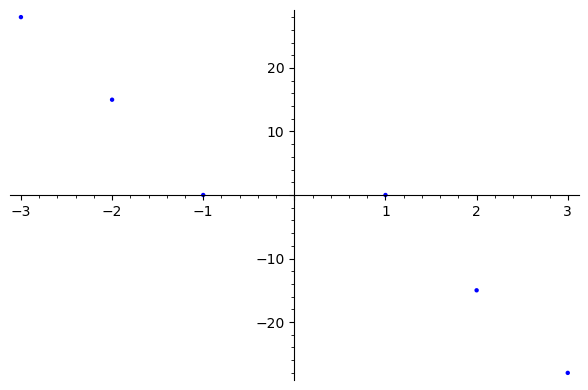

(0, -15, -28)
-3 3
-2 2
-1 1
1 2
2 1
3 1


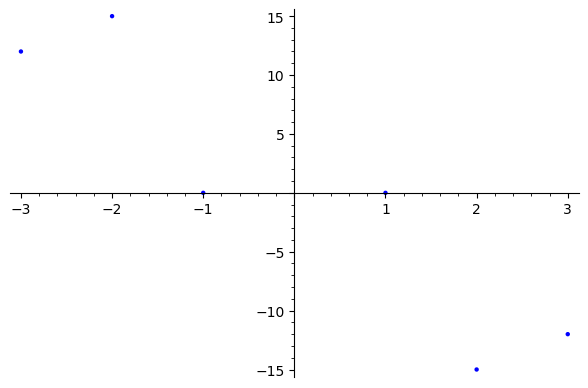

(0, -15, -12)
-3 1
-2 2
-1 1
1 2
2 1
3 1


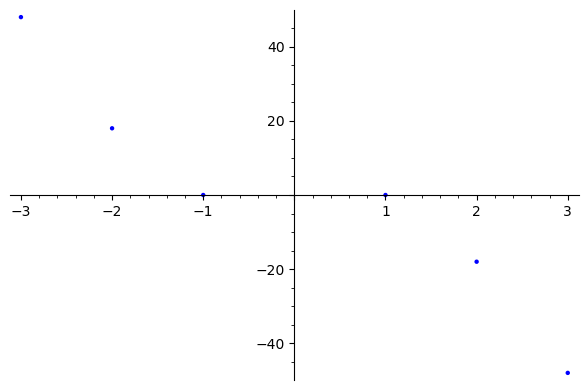

(0, -18, -48)
-3 3
-2 2
-1 1
1 1
2 1
3 1


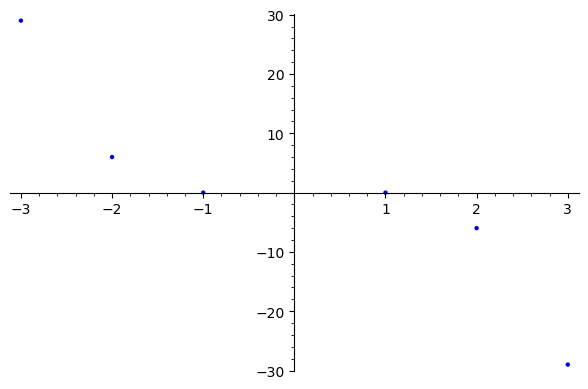

(0, -6, -29)
-3 4
-2 2
-1 1
1 1
2 1
3 1


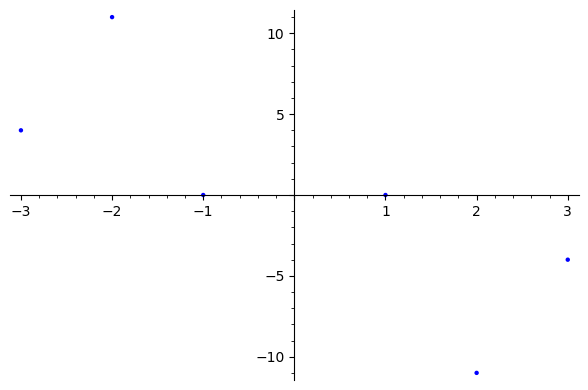

(0, -11, -4)
-3 1
-2 4
-1 1
1 2
2 1
3 1


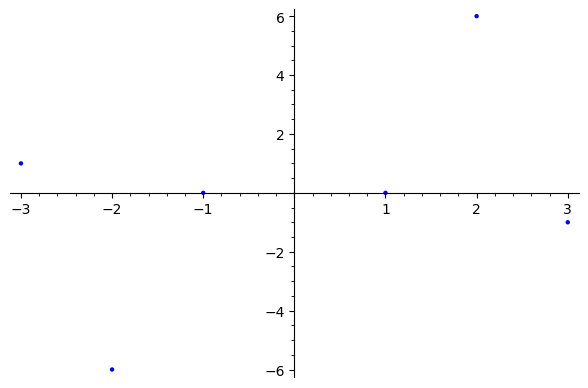

(0, 6, -1)
-3 4
-2 1
-1 2
1 1
2 1
3 1


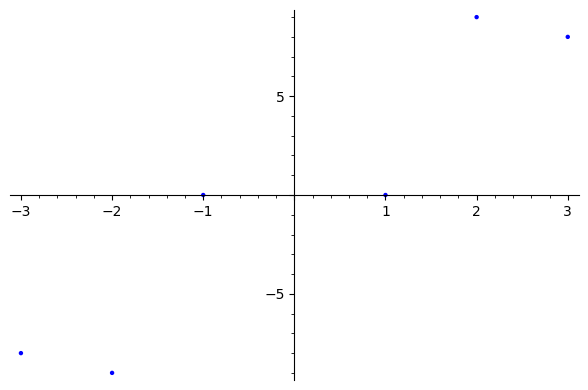

(0, 9, 8)
-3 2
-2 1
-1 2
1 1
2 1
3 1


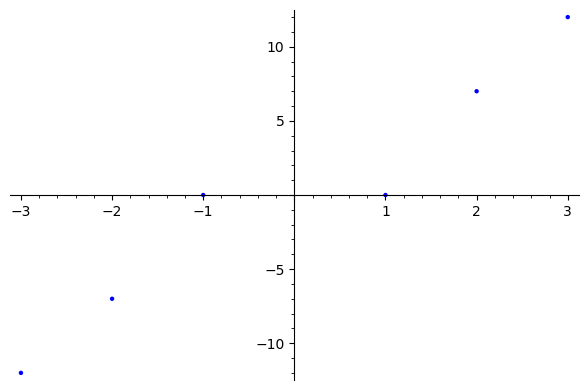

(0, 7, 12)
-3 2
-2 1
-1 3
1 1
2 1
3 1


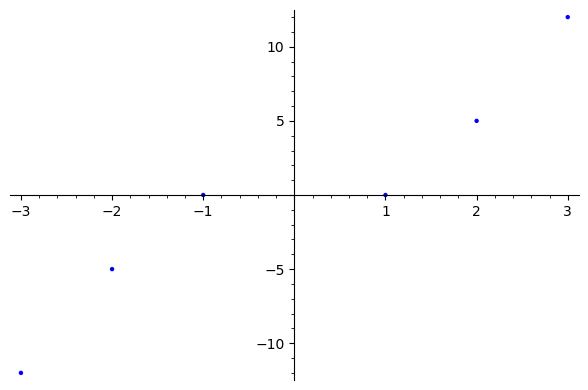

(0, 5, 12)
-3 1
-2 1
-1 3
1 2
2 1
3 1


In [34]:
def argmax(L):
    k, m = 0, -oo
    for j in range(len(L)):
        if L[j] > m:
            k, m = j, L[j]
    return k

n = 3
print("n =", n)
P = polytopes.cross_polytope(n)
c = vector(range(1, n+1))
M = PP(P, c)
V = [vector((0, 0, -1)), vector((0, -1, 0)), vector((-1, 0, 0)), vector((1, 0, 0)), vector((0, 1, 0)), vector((0, 0, 1))]
print(M)
N = [-f.vector()[1:] for f in M.Hrepresentation()]
VV = []
for v in M.faces(0):
    VV.append(v.ambient_H_indices())
VV = [sum(N[i] for i in v[1:]) for v in VV]
VV
for w in VV:
    Q = sum(plot(point((u.dot_product(c), u.dot_product(w)))) for u in V)
    Q.show()
    print(w)
    for i in range(2*n):
        print(i-3+int(i>2), 1+argmax([((V[j]-V[i]).dot_product(w)) / ((V[j]-V[i]).dot_product(c)) for j in range(i+1, 2*n)]))

In [8]:
for n in range(3, 8):
    print("n =", n)
    c = vector(range(1, n+1))
    for k in range(2, n//2+1):
        print(" k =", k)
        P = polytopes.hypersimplex(n, k)
        print("", PP(P, c))
    print()

n = 3

n = 4
 k = 2
 A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 9 vertices

n = 5
 k = 2
 A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 60 vertices

n = 6
 k = 2
 A 4-dimensional polyhedron in QQ^6 defined as the convex hull of 536 vertices
 k = 3
 A 4-dimensional polyhedron in QQ^6 defined as the convex hull of 1126 vertices

n = 7
 k = 2
 A 5-dimensional polyhedron in QQ^7 defined as the convex hull of 5838 vertices
 k = 3


KeyboardInterrupt: 

$k = 2$ ($n = 4$ on):
$9, 60, 536, 5838, ...$

$k = 3$ ($n = 6$ on):
$1126, ...$

In [10]:
# MPP of hypersimplices (please check code: orientation not generic)
for n in range(3, 11):
    print("n =", n)
    for k in range(2, n//2+1):
        print(" k =", k)
        for s in range(n):
            c = vector([int(i <= s) for i in range(n)])
            print("  c =", c)
            P = polytopes.hypersimplex(n, k)
            print("", MPP(P, c))
        print()
    print()

n = 3

n = 4
 k = 2
  c = (1, 0, 0, 0)
 A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 6 vertices
  c = (1, 1, 0, 0)
 A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 4 vertices
  c = (1, 1, 1, 0)
 A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 6 vertices
  c = (1, 1, 1, 1)
 A 3-dimensional polyhedron in QQ^4 defined as the convex hull of 6 vertices


n = 5
 k = 2
  c = (1, 0, 0, 0, 0)
 A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 12 vertices
  c = (1, 1, 0, 0, 0)
 A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 12 vertices
  c = (1, 1, 1, 0, 0)
 A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 12 vertices
  c = (1, 1, 1, 1, 0)
 A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 12 vertices
  c = (1, 1, 1, 1, 1)
 A 4-dimensional polyhedron in QQ^5 defined as the convex hull of 10 vertices


n = 6
 k = 2
  c = (1, 0, 0, 0, 0, 0)
 A 4-dimensional polyhedron in QQ^6 defin

KeyboardInterrupt: 

In [13]:
for n in range(3, 8):
    print("n =", n)
    for s in range(n//2):
        c = vector([int(i <= s) for i in range(n)])
        print("  c =", c)
        P = polytopes.permutahedron(n)
        print("MPP:", MPP(P, c))
        print("PP :", PP(P, c))
    print()

n = 3
  c = (1, 0, 0)
MPP: A 1-dimensional polyhedron in QQ^3 defined as the convex hull of 2 vertices
PP : A 1-dimensional polyhedron in QQ^3 defined as the convex hull of 2 vertices

n = 4
  c = (1, 0, 0, 0)
MPP: A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 6 vertices
PP : A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 7 vertices
  c = (1, 1, 0, 0)
MPP: A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 8 vertices
PP : A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 8 vertices

n = 5
  c = (1, 0, 0, 0, 0)
MPP: A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 24 vertices
PP : A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 56 vertices
  c = (1, 1, 0, 0, 0)
MPP: A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 60 vertices
PP : A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 66 vertices

n = 6
  c = (1, 0, 0, 0, 0, 0)


KeyboardInterrupt: 

For $S$ with $|S| = 1$, then MPP($\Pi_n, \mathbf{e}_S$) $= \Pi_{n-1}$.

This is clear by considering the projection of the normal fan of $\Pi_n$ along the vector $\mathbf{e}_S$ : we recover the normal fan of $\Pi_{n-1}$.

In [6]:
# PP of hypersimplices (please check code: orientation not generic)
for n in range(3, 8):
    print("n =", n)
    for k in range(2, n//2+1):
        print(" k =", k)
        for s in range(n):
            c = vector([int(i <= s) for i in range(n)])
            print("  c =", c)
            P = polytopes.hypersimplex(n, k)
            print("", PP(P, c))
        print()
    print()

n = 3

n = 4
 k = 2
  c = (1, 0, 0, 0)
 A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 6 vertices
  c = (1, 1, 0, 0)
 A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 5 vertices
  c = (1, 1, 1, 0)
 A 2-dimensional polyhedron in QQ^4 defined as the convex hull of 6 vertices
  c = (1, 1, 1, 1)
 A 0-dimensional polyhedron in ZZ^4 defined as the convex hull of 1 vertex


n = 5
 k = 2
  c = (1, 0, 0, 0, 0)
 A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 26 vertices
  c = (1, 1, 0, 0, 0)
 A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 19 vertices
  c = (1, 1, 1, 0, 0)
 A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 19 vertices
  c = (1, 1, 1, 1, 0)
 A 3-dimensional polyhedron in QQ^5 defined as the convex hull of 14 vertices
  c = (1, 1, 1, 1, 1)
 A 0-dimensional polyhedron in ZZ^5 defined as the convex hull of 1 vertex


n = 6
 k = 2
  c = (1, 0, 0, 0, 0, 0)
 A 4-dimensional polyhedron in QQ^6 defined as

KeyboardInterrupt: 

In [14]:
def Delta(X, n=-1):
    if n == -1:
        n = max(X) + 1
    return Polyhedron(vertices=[[int(i == x) for i in range(n)] for x in X])

n = 4
X = {0, 1, 2}
Y = {0, 3, 4}
P, Q = Delta(X, n), Delta(Y, n)
print(P)
print(Q)
print()
print(P*Q)
print((P*Q).graph().num_edges())
print(P+Q)
print((P+Q).graph().num_edges())
(P+Q).show()

A 2-dimensional polyhedron in ZZ^4 defined as the convex hull of 3 vertices
A 2-dimensional polyhedron in ZZ^4 defined as the convex hull of 3 vertices

A 4-dimensional polyhedron in ZZ^8 defined as the convex hull of 9 vertices
18
A 4-dimensional polyhedron in ZZ^4 defined as the convex hull of 9 vertices
18


Graphics3d Object

In [12]:
c = vector([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
R = PP(P*Q, c)
print(R)
print(R.is_combinatorially_isomorphic(polytopes.permutahedron(4)))

print()
c = vector([1, 2, 3, 4, 5, 6])
R = PP(P+Q, c)
print(R)
print(R.is_combinatorially_isomorphic(polytopes.permutahedron(4)))

A 4-dimensional polyhedron in QQ^12 defined as the convex hull of 108 vertices
False

A 4-dimensional polyhedron in QQ^6 defined as the convex hull of 108 vertices
False
